In [1]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("stanford_dogs", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

/home/apprenant/miniconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-07 10:06:46.954396: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 10:06:47.165507: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-07 10:06:47.165531: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU 

In [2]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "stanford_dogs",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

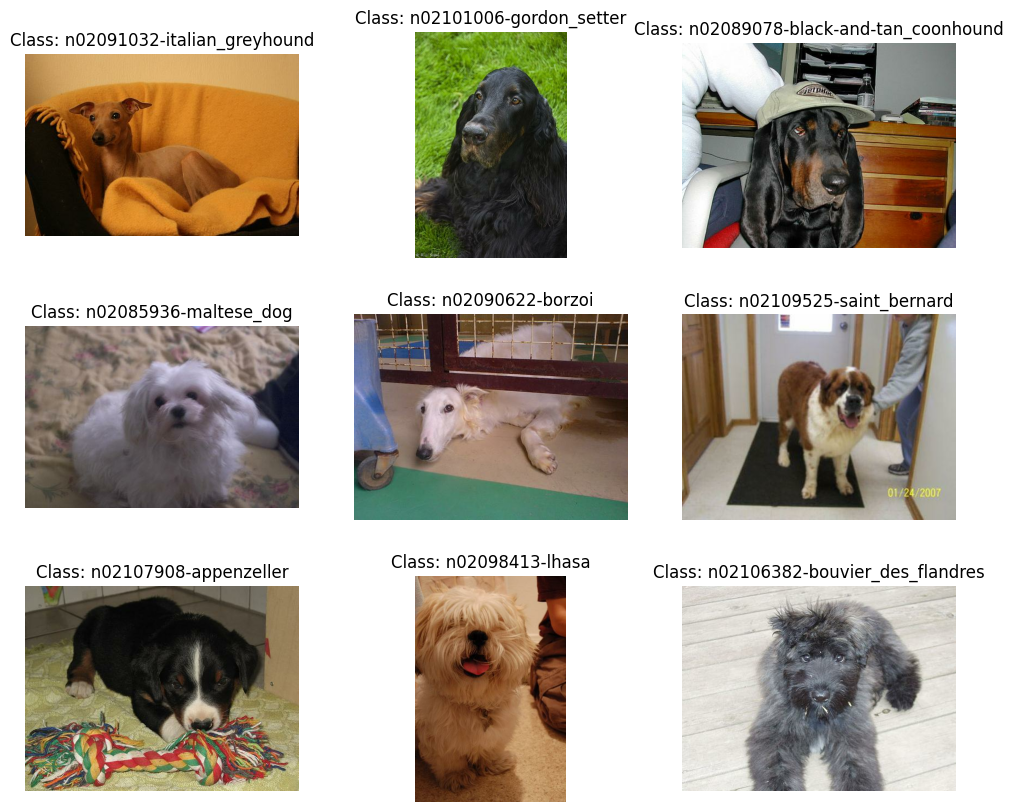

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
index = 0
for image, label in valid_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [5]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
keras.utils.set_random_seed(42)

In [6]:
base_model = tf.keras.applications.EfficientNetB4(weights="imagenet",include_top=False)

In [7]:
batch_size=32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=128, width=128, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input
)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [8]:
# plt.figure(figsize=(12, 12))
# for X_batch, y_batch in valid_set.take(1):
#     for index in range(9):
#         plt.subplot(3, 3, index + 1)
#         plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
#         plt.title(f"Class: {class_names[y_batch[index]]}")
#         plt.axis("off")

# plt.show()

In [9]:
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [10]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_1                33: block2a_dwconv_pad     66: block2c_se_reshape     99: block3a_se_expand     
  1: rescaling              34: block2a_dwconv         67: block2c_se_reduce     100: block3a_se_excite     
  2: normalization          35: block2a_bn             68: block2c_se_expand     101: block3a_project_conv  
  3: rescaling_1            36: block2a_activation     69: block2c_se_excite     102: block3a_project_bn    
  4: stem_conv_pad          37: block2a_se_squeeze     70: block2c_project_conv  103: block3b_expand_conv   
  5: stem_conv              38: block2a_se_reshape     71: block2c_project_bn    104: block3b_expand_bn     
  6: stem_bn                39: block2a_se_reduce      72: block2c_drop          105: block3b_expand_activation
  7: stem_activation        40: block2a_se_expand      73: block2c_add           106: block3b_dwconv        
  8: block1a_dwconv         41: block2a_se_excite      74: block2d_expand_conv   107: block3b_bn            
  9: block1a_bn 

In [11]:
for layer in base_model.layers:
    layer.trainable = False

In [13]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True),
]

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

history = model.fit(train_set, validation_data=valid_set, epochs=3,callbacks=my_callbacks)

Epoch 1/3
282/282 [==============================] - 253s 848ms/step - loss: 1.6338 - accuracy: 0.5842 - val_loss: 1.2206 - val_accuracy: 0.6722
Epoch 2/3
229/282 [=======================>......] - ETA: 35s - loss: 0.8126 - accuracy: 0.7590

KeyboardInterrupt: 